Chemistry-Informed Polymer Electrolyte Prediction for Ionic Conductivity - Featurization

In this code, the goal is to find best features to predict ionic conductivity using only molecular features from RDkit and physics-informed equations. The features of interests are chosen either through literature or chemical intuition, but must be available on or able to be calculated using RDkit. Once this is complete, correlation matrix and linear regression will first be used to predict for ionic conductivity and see if the features are feasible for the next step of applying it into Random Forest. 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, rdmolops
import rdkit.Chem as Chem_mod
from rdkit.Chem import rdPartialCharges

from rdkit.Chem import BRICS
from rdkit.Chem import EState

Let's observe the original dataset first. We will load the dataset and use pearson correlation matrix to see how each parameters linked to each other.

In [26]:
df = pd.read_csv('TRI_data.csv')
print(len(df))
df.head()


6137


,Trajectory ID,Mol smiles,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,Transference Number
0,9425,COCC(CNCC(CF)OC(=O)[Au])O[Cu],1.4005,467.71,19.0,1.3494,0.000076,3.229400e-08,1.260800e-08,1.526400e-08,-0.162760
1,9426,O=C(CCNC(=O)COC(=O)[Au])NCCN[Cu],1.4735,475.72,13.0,1.4561,0.000070,1.317300e-08,1.105800e-08,8.636900e-09,0.317530
2,9427,NC(=O)C(COC(=O)[Au])NC(=O)CCO[Cu],1.4422,462.68,17.0,1.5336,0.000104,1.397400e-08,1.952200e-08,9.183200e-09,0.529740
3,9428,CC(COC(=O)[Au])COC(=O)C(C)(C)CO[Cu],1.4327,476.75,16.0,1.2767,0.000027,2.421000e-08,1.192500e-08,1.402700e-08,-0.319160
4,9429,COC(=O)CC(=O)NC(CO[Cu])COC(=O)[Au],1.4680,477.69,26.0,1.4896,0.000038,1.349100e-08,6.582900e-09,8.672500e-09,0.080645


In [27]:
num_dupe = df.duplicated().sum() 
num_miss = df.isnull().values.any() 

print(f"Number of duplicate rows: {num_dupe}")
print(f"Number of missing values: {num_miss}")

Number of duplicate rows: 0
Number of missing values: False


In [28]:
df.columns

Index(['Trajectory ID', 'Mol smiles', 'Molality', 'Monomer Molecular Weight',
       'Degree of Polymerization', 'Density', 'CONDUCTIVITY',
       'TFSI Diffusivity', 'Li Diffusivity', 'Poly Diffusivity',
       'Transference Number'],
      dtype='object')

In [29]:
columns = ['Molality', 'Monomer Molecular Weight',
       'Degree of Polymerization', 'Density', 'CONDUCTIVITY',
       'TFSI Diffusivity', 'Li Diffusivity', 'Poly Diffusivity',
       'Transference Number'] # selecting all the numerical columns
all_outliers = set() # remove outlier using z-score method
threshold = 3

for col in columns[0:]:
    cleaned_col = df[col].dropna()
    z_scores = np.abs(stats.zscore(cleaned_col))
    outlier_indices = cleaned_col.index[z_scores > threshold]

    if len(outlier_indices) > 0:
        print(f"Outliers detected in '{col}' (count: {len(outlier_indices)}):")
        print(df.loc[outlier_indices, [col]], "\n")
    else:
        print(f"No outliers detected in '{col}'.\n")

Outliers detected in 'Molality' (count: 2):
      Molality
1645    4.3689
1649    3.8132 

Outliers detected in 'Monomer Molecular Weight' (count: 141):
      Monomer Molecular Weight
43                      387.66
108                     371.61
124                     389.67
374                     389.67
475                     389.67
...                        ...
5993                    390.62
6018                    374.66
6022                    390.66
6065                    388.64
6103                    390.62

[141 rows x 1 columns] 

Outliers detected in 'Degree of Polymerization' (count: 5):
      Degree of Polymerization
1649                      76.0
1653                      76.0
1673                      51.0
1674                      51.0
1676                      51.0 

Outliers detected in 'Density' (count: 70):
      Density
296    1.6239
880    1.6203
1274   1.6208
1383   1.6536
1439   1.6595
...       ...
6025   1.6307
6049   1.6483
6078   1.6810
6090   1.7283
610

In [30]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Trajectory ID             6137 non-null   int64  
 1   Mol smiles                6137 non-null   object 
 2   Molality                  6137 non-null   float64
 3   Monomer Molecular Weight  6137 non-null   float64
 4   Degree of Polymerization  6137 non-null   float64
 5   Density                   6137 non-null   float64
 6   CONDUCTIVITY              6137 non-null   float64
 7   TFSI Diffusivity          6137 non-null   float64
 8   Li Diffusivity            6137 non-null   float64
 9   Poly Diffusivity          6137 non-null   float64
 10  Transference Number       6137 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 527.5+ KB
None


In [31]:
# first, we remove the tracer particles, [Au] and [Cu], from the SMILES strings
df["Mol_smiles_clean"] = (
    df["Mol smiles"]
    .str.replace(r"\[Cu\]", "", regex=True)
    .str.replace(r"\[Au\]", "", regex=True)
    .str.replace(r"\(\)", "", regex=True)   # <-- fixes empty parentheses
    .str.strip()
)

# we then validate the SMILES strings by attempting to convert them to RDKit Mol objects
valid_list = []
mol_list = []
for smi in df["Mol_smiles_clean"]:
    try:
        mol = Chem.MolFromSmiles(smi)
        mol_list.append(mol)
        valid_list.append(mol is not None)
    except:
        mol_list.append(None)
        valid_list.append(False)

df["is_valid"] = valid_list
df["mol_obj"] = mol_list

df_valid = df[df["is_valid"]].copy()

print(f"Valid molecules: {df_valid.shape[0]} / {df.shape[0]}")
df.head()

Valid molecules: 6137 / 6137


,Trajectory ID,Mol smiles,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,Transference Number,Mol_smiles_clean,is_valid,mol_obj
0,9425,COCC(CNCC(CF)OC(=O)[Au])O[Cu],1.4005,467.71,19.0,1.3494,0.000076,3.229400e-08,1.260800e-08,1.526400e-08,-0.162760,COCC(CNCC(CF)OC(=O))O,True,<rdkit.Chem.rdchem.Mol object at 0x1a7fc00b0>
1,9426,O=C(CCNC(=O)COC(=O)[Au])NCCN[Cu],1.4735,475.72,13.0,1.4561,0.000070,1.317300e-08,1.105800e-08,8.636900e-09,0.317530,O=C(CCNC(=O)COC(=O))NCCN,True,<rdkit.Chem.rdchem.Mol object at 0x1abf09d90>
2,9427,NC(=O)C(COC(=O)[Au])NC(=O)CCO[Cu],1.4422,462.68,17.0,1.5336,0.000104,1.397400e-08,1.952200e-08,9.183200e-09,0.529740,NC(=O)C(COC(=O))NC(=O)CCO,True,<rdkit.Chem.rdchem.Mol object at 0x1abf0a180>
3,9428,CC(COC(=O)[Au])COC(=O)C(C)(C)CO[Cu],1.4327,476.75,16.0,1.2767,0.000027,2.421000e-08,1.192500e-08,1.402700e-08,-0.319160,CC(COC(=O))COC(=O)C(C)(C)CO,True,<rdkit.Chem.rdchem.Mol object at 0x1abf0a1f0>
4,9429,COC(=O)CC(=O)NC(CO[Cu])COC(=O)[Au],1.4680,477.69,26.0,1.4896,0.000038,1.349100e-08,6.582900e-09,8.672500e-09,0.080645,COC(=O)CC(=O)NC(CO)COC(=O),True,<rdkit.Chem.rdchem.Mol object at 0x1abf0a260>



=== Correlation with ionic conductivity ===
CONDUCTIVITY                1.000000
Poly Diffusivity            0.764451
Li Diffusivity              0.760050
TFSI Diffusivity            0.730681
Transference Number         0.218623
Molality                    0.085312
Density                    -0.018543
Monomer Molecular Weight   -0.033365
Trajectory ID              -0.116607
Degree of Polymerization   -0.155122
Name: CONDUCTIVITY, dtype: float64


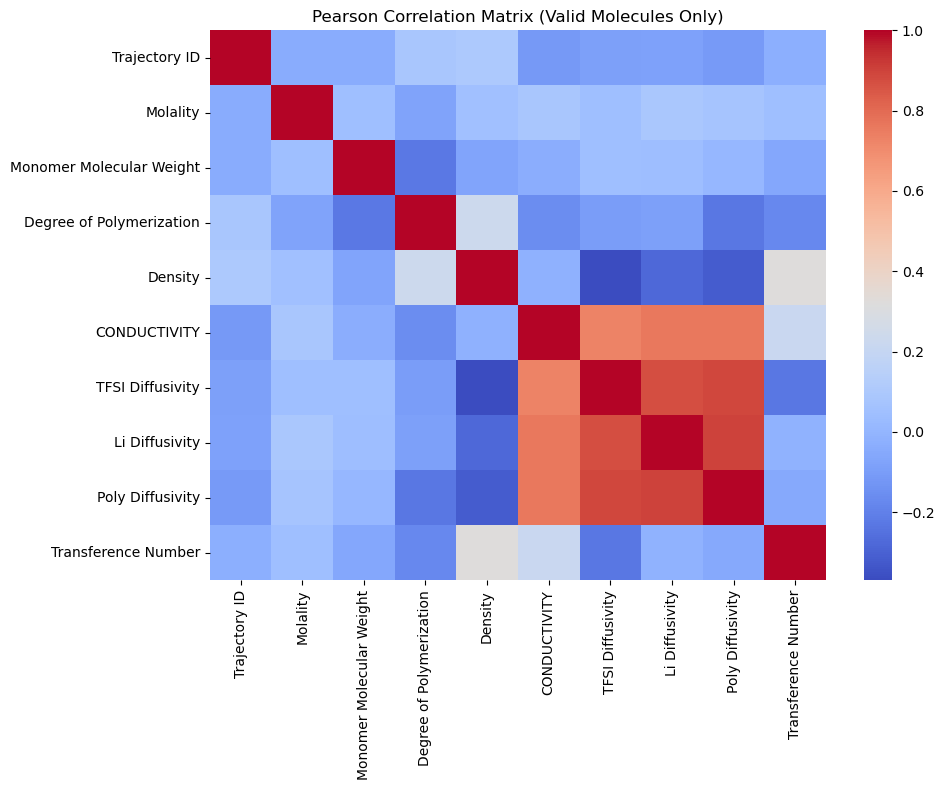

In [32]:
# let's see how the features correlate with ionic conductivity first

numeric_cols = df_valid.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Change this if your column name differs
target = "CONDUCTIVITY"

if target not in numeric_cols:
    raise ValueError(f"Column '{target}' not found among numeric columns.")

corr_matrix = df_valid[numeric_cols].corr(method="pearson")

# Show correlations with ionic conductivity
corr_target = corr_matrix[target].sort_values(ascending=False)
print("\n=== Correlation with ionic conductivity ===")
print(corr_target)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Pearson Correlation Matrix (Valid Molecules Only)")
plt.tight_layout()
plt.show()

Here, we can see that features correlated to ionic conductivity the most are those that are dependent on molecular dynamics. To show the effect of molecular features, we will remove the MD-dependent descriptors to see if our molecular descriptor + polymer physics dataset can stand up to par to the MD-dependent descriptors.

In [33]:
# we start off with the simplest: individual element and counts as features

all_elements = set()
for mol in df_valid["mol_obj"]:
    for atom in mol.GetAtoms():
        all_elements.add(atom.GetSymbol())

print("All detected elements:", all_elements)

def count_elements(mol, elements):
    counts = {f"Count_{e}": 0 for e in elements}
    for atom in mol.GetAtoms():
        sym = atom.GetSymbol()
        if sym in elements:
            counts[f"Count_{sym}"] += 1
    return counts


element_feature_rows = [count_elements(mol, all_elements) for mol in df_valid["mol_obj"]]
df_elements = pd.DataFrame(element_feature_rows)

# we then proceed to count the number of heteroatoms. this is because they can promote ion transfer and enhance conductivity

main_elements = {"C", "H", "O", "N"} # remove main elements: C, H, O, N

hetero_cols = [col for col in df_elements.columns if col.replace("Count_", "") not in main_elements]

df_elements["Heteroatom_count"] = df_elements[hetero_cols].sum(axis=1)
df_elements.head()


All detected elements: {'Cl', 'O', 'S', 'P', 'Si', 'C', 'N', 'F'}


,Count_Cl,Count_O,Count_S,Count_P,Count_Si,Count_C,Count_N,Count_F,Heteroatom_count
0,0,4,0,0,0,8,1,1,1
1,0,4,0,0,0,8,3,0,0
2,0,5,0,0,0,7,2,0,0
3,0,5,0,0,0,10,0,0,0
4,0,6,0,0,0,8,1,0,0


Our next step is to implement chain-level, block-level, and atomic-level fragments. These were found in the literature to be relevant to materials property prediction, and thus we are curious as to how this will effect electrochemical properties such as ionic conductivity.

In [34]:
# Chain-level features:
# Topological diameter = maximum chain length between any two atoms (bonds) can affect ion transport

chain_features = []

for mol in df_valid["mol_obj"]:
    dm = rdmolops.GetDistanceMatrix(mol)
    dm = np.array(dm, dtype=float)
    
    diam = np.nanmax(dm) if dm.size > 0 else np.nan # maximum shortest-path distance (topological diameter)
    
    chain_features.append({"Topological_diameter_bonds": diam})

df_chain = pd.DataFrame(chain_features)
df_chain.head()


,Topological_diameter_bonds
0,10.0
1,12.0
2,9.0
3,10.0
4,10.0


In [35]:
# BRICS (block-level) fragment features:
# 1. unique BRICS fragment count - higher unique BRICS fragment counts can influence ion pathways due to complexity
# 2. largest heavy atoms BRICS fragment - larger blocks can hinder ion mobility

brics_data = []

for mol in df_valid["mol_obj"]:

    frag_smiles = BRICS.BRICSDecompose(mol) # BRICS decomposition → returns a set of fragment SMILES
    frag_list = list(frag_smiles)

    unique_frag_count = len(frag_list)

    sizes = [] # heavy atom counts of each fragment
    for smi in frag_list:
        fm = Chem.MolFromSmiles(smi)
        if fm:
            sizes.append(rdMolDescriptors.CalcNumHeavyAtoms(fm))

    largest_frag_size = max(sizes) if sizes else np.nan # largest fragment size (heavy atoms)

    # Store features
    brics_data.append({
        "BRICS_unique_frag_count": unique_frag_count,
        "BRICS_largest_frag_heavy_atoms": largest_frag_size
    })

df_brics = pd.DataFrame(brics_data)
df_brics.head()


,BRICS_unique_frag_count,BRICS_largest_frag_heavy_atoms
0,5,4
1,5,4
2,4,5
3,4,7
4,5,5


In [36]:
# Atomic-level fragment features:
# 1. Functional group counts (using SMARTS)
# 2. Ring counts
# 3. Hybridization counts
# 4. H-bond donors / acceptors

atomic_rows = []

# Define SMARTS patterns for common functional groups (only selected ion-containing functional groups)
# SMARTS is used instead of SMILES because it can capture patterns like hybridization, ring membership, and hydrogen counts

smarts_patterns = {
   "carbonyl": "[CX3]=O",
    "ester": "[CX3](=O)[OX2H0]",
    "amide": "[NX3][CX3](=O)",
    "ether": "C-O-C",
    "alcohol": "[OX2H]"
}
compiled_smarts = {name: Chem.MolFromSmarts(pattern) for name, pattern in smarts_patterns.items()}

for mol in df_valid["mol_obj"]:

    atom_features = {}

    # functional group counts
    for name, patt in compiled_smarts.items():
        if patt is None:
            atom_features[f"Fgroup_{name}"] = np.nan
        else:
            matches = mol.GetSubstructMatches(patt)
            atom_features[f"Fgroup_{name}"] = len(matches)

    # ring counts and if they are aromatic
    atom_features["RingCount"] = mol.GetRingInfo().NumRings() 
    atom_features["AromaticAtomCount"] = sum(1 for a in mol.GetAtoms() if a.GetIsAromatic())

    # hybridization counts
    hyb_counts = {"SP":0,"SP2":0,"SP3":0}
    for a in mol.GetAtoms():
        hyb = str(a.GetHybridization())
        if "SP3" in hyb: hyb_counts["SP3"] += 1
        elif "SP2" in hyb: hyb_counts["SP2"] += 1
        elif "SP" in hyb: hyb_counts["SP"] += 1
    atom_features.update({f"Hybrid_{k}": v for k, v in hyb_counts.items()})

    # hydrogen bond donors / acceptors
    atom_features["NumHDonors"] = rdMolDescriptors.CalcNumHBD(mol)
    atom_features["NumHAcceptors"] = rdMolDescriptors.CalcNumHBA(mol)

    atomic_rows.append(atom_features)

df_atomic = pd.DataFrame(atomic_rows)
df_atomic.head()


,Fgroup_carbonyl,Fgroup_ester,Fgroup_amide,Fgroup_ether,Fgroup_alcohol,RingCount,AromaticAtomCount,Hybrid_SP,Hybrid_SP2,Hybrid_SP3,NumHDonors,NumHAcceptors
0,1,1,0,2,1,0,0,0,3,11,2,5
1,3,1,2,1,0,0,0,0,9,6,3,5
2,3,1,2,1,1,0,0,0,9,5,3,5
3,2,2,0,2,1,0,0,0,6,9,1,5
4,3,2,1,2,1,0,0,0,9,6,2,6


In [37]:
# electrotopological State (EState) per molecule aggregated features:
# per-atom descriptor combining electronic effects and topological environment; captures how "electronically accessible" each atom is in a molecule

estate_rows = []

for mol in df_valid["mol_obj"]:
    
    estate_vals = EState.EStateIndices(mol)
    estate_vals = [float(x) for x in estate_vals]  
    
    # Aggregate per-atom EState into molecule-level descriptors
    estate_features = {
        "EState_sum": np.nansum(estate_vals),      # total EState
        "EState_max": float(np.nanmax(estate_vals)),     # most polarized / reactive atom
        "EState_min": float(np.nanmin(estate_vals)),     # least polarized / reactive atom
        "EState_std": np.nanstd(estate_vals),       # variation across atoms
        "EState_mean": np.nanmean(estate_vals)       # average EState across atoms

    }
    
    estate_rows.append(estate_features)

df_estate = pd.DataFrame(estate_rows)
df_estate.head()


,EState_sum,EState_max,EState_min,EState_std,EState_mean
0,43.166667,12.105997,-0.789588,4.210616,3.083333
1,46.333333,10.992087,-0.436366,4.063489,3.088889
2,48.166667,10.898291,-1.056250,4.502828,3.440476
3,43.750000,11.381498,-0.883694,3.946091,2.916667
4,49.666667,11.077874,-0.715411,4.407540,3.311111


In [38]:
# Gasteiger/Partial charges:
# - Approximate atomic charges based on electronegativity equilibration and can be used for modeling electrostatic interactions, polarity, and ion binding

charge_rows = []

for mol in df_valid["mol_obj"]:
    
    mol_copy = Chem.Mol(mol) # copy is needed for Gasteiger computation
    AllChem.ComputeGasteigerCharges(mol_copy) # compute Gasteiger charges
    
    g_charges = [float(atom.GetProp("_GasteigerCharge")) for atom in mol_copy.GetAtoms()]
    
    g_max = np.max(g_charges) # most positive atom
    g_min = np.min(g_charges) # most negative atom
    g_mean = np.mean(g_charges) # average charge
    g_std = np.std(g_charges) # charge variability

    charge_rows.append({
        "Gasteiger_max": g_max,
        "Gasteiger_min": g_min,
        "Gasteiger_mean": g_mean,
        "Gasteiger_std": g_std
    })

df_charges = pd.DataFrame(charge_rows)
df_charges.head()


,Gasteiger_max,Gasteiger_min,Gasteiger_mean,Gasteiger_std
0,0.292994,-0.460432,-0.087493,0.233611
1,0.293089,-0.457795,-0.083026,0.246671
2,0.292667,-0.465137,-0.089431,0.262205
3,0.313355,-0.467479,-0.067783,0.241140
4,0.314539,-0.468620,-0.076548,0.272433


In [39]:
# Solvent Accessible Surface Area (SASA) / van der Waals surface area:
# approximates the exposed surface area of a molecule, related to solvation, ion accessibility, and polymer segment exposure
# note: larger exposed polar areas → better ion mobility

sasa_rows = []

for mol in df_valid["mol_obj"]:

    mol_h = Chem.AddHs(mol) # add hydrogens for more accurate surface area
    
    sasa_sum = rdMolDescriptors.CalcLabuteASA(mol_h) # Labute's method for SASA approximation - faster than full SASA calc bc does not require 3D coords
    
    sasa_rows.append({
        "SASA_sum": float(sasa_sum)
    })

df_sasa = pd.DataFrame(sasa_rows)
df_sasa.head()


,SASA_sum
0,104.816345
1,108.638356
2,97.331488
3,114.744238
4,104.758942


In [40]:
# extra descriptors from RDKit that maybe useful for predicting ionic conductivity

desc_rows = []

for mol in df_valid["mol_obj"]:
    row = {
        "MolLogP": Descriptors.MolLogP(mol), # polymer polarity
        "TPSA": rdMolDescriptors.CalcTPSA(mol), # polar surface area 
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol), # flexibility
        "FractionCSP3": Descriptors.FractionCSP3(mol), # carbon hybridization fraction - how many there are sp3 carbons vs total carbons
    }
    desc_rows.append(row)

df_desc = pd.DataFrame(desc_rows)
df_desc.head()


,MolLogP,TPSA,NumRotatableBonds,FractionCSP3
0,-0.9056,67.79,9,0.875000
1,-2.2594,110.52,8,0.625000
2,-2.4881,118.72,7,0.571429
3,0.3572,72.83,7,0.800000
4,-1.8004,101.93,7,0.625000


In [41]:
# polymer physics descriptors - here, we use RDkit to calculate descriptors based on polymer-relevant physical properties
# note that these are the approximate estimations and may not be highly accurate, but can still provide useful trends for ML models

# we first set the constants to match original dataset
kB = 1.380649e-23  # J/K
T = 353  # K

df_physics = pd.DataFrame()

df_physics["R_eff"] = (df_valid["Monomer Molecular Weight"] ** (1/3)) * 1e-10 # Effective hydrodynamic radius (very rough, size ∝ MW^(1/3))
df_physics["D"] = kB * T / (6 * np.pi * 1e-3 * df_physics["R_eff"]) # Pseudo Stokes–Einstein diffusion coefficient of polymer chains
df_physics["Tg"] = (50 + 0.1 * df_valid["Monomer Molecular Weight"] + 0.2 * df_desc["TPSA"] - 1.0 * df_desc["NumRotatableBonds"]) # Glass-transition (linear combo of MW, TPSA, rotors)
df_physics["eta"] = df_physics["Tg"] / (df_desc["FractionCSP3"] + 1e-3) # Viscosity (higher Tg + lower flexibility → higher viscosity)

df_physics.head()

,R_eff,D,Tg,eta
0,7.762332e-10,3.330923e-10,101.329,115.672374
1,7.806394e-10,3.312123e-10,111.676,178.396166
2,7.734405e-10,3.342951e-10,113.012,197.425505
3,7.812024e-10,3.309736e-10,105.241,131.387016
4,7.817155e-10,3.307563e-10,111.155,177.563898


In [42]:
# create final feature dataframe by concatenating all feature dataframes

df_final = pd.concat([
    df_valid.reset_index(drop=True),
    df_chain.reset_index(drop=True),
    df_brics.reset_index(drop=True),
    df_atomic.reset_index(drop=True),
    df_estate.reset_index(drop=True),
    df_charges.reset_index(drop=True),
    df_sasa.reset_index(drop=True),
    df_desc.reset_index(drop=True),
    df_physics.reset_index(drop=True)
], axis=1)

df_final.head()

,Trajectory ID,Mol smiles,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,...,Gasteiger_std,SASA_sum,MolLogP,TPSA,NumRotatableBonds,FractionCSP3,R_eff,D,Tg,eta
0,9425,COCC(CNCC(CF)OC(=O)[Au])O[Cu],1.4005,467.71,19.0,1.3494,0.000076,3.229400e-08,1.260800e-08,1.526400e-08,...,0.233611,104.816345,-0.9056,67.79,9,0.875000,7.762332e-10,3.330923e-10,101.329,115.672374
1,9426,O=C(CCNC(=O)COC(=O)[Au])NCCN[Cu],1.4735,475.72,13.0,1.4561,0.000070,1.317300e-08,1.105800e-08,8.636900e-09,...,0.246671,108.638356,-2.2594,110.52,8,0.625000,7.806394e-10,3.312123e-10,111.676,178.396166
2,9427,NC(=O)C(COC(=O)[Au])NC(=O)CCO[Cu],1.4422,462.68,17.0,1.5336,0.000104,1.397400e-08,1.952200e-08,9.183200e-09,...,0.262205,97.331488,-2.4881,118.72,7,0.571429,7.734405e-10,3.342951e-10,113.012,197.425505
3,9428,CC(COC(=O)[Au])COC(=O)C(C)(C)CO[Cu],1.4327,476.75,16.0,1.2767,0.000027,2.421000e-08,1.192500e-08,1.402700e-08,...,0.241140,114.744238,0.3572,72.83,7,0.800000,7.812024e-10,3.309736e-10,105.241,131.387016
4,9429,COC(=O)CC(=O)NC(CO[Cu])COC(=O)[Au],1.4680,477.69,26.0,1.4896,0.000038,1.349100e-08,6.582900e-09,8.672500e-09,...,0.272433,104.758942,-1.8004,101.93,7,0.625000,7.817155e-10,3.307563e-10,111.155,177.563898


In [43]:
df_final.columns

Index(['Trajectory ID', 'Mol smiles', 'Molality', 'Monomer Molecular Weight',
       'Degree of Polymerization', 'Density', 'CONDUCTIVITY',
       'TFSI Diffusivity', 'Li Diffusivity', 'Poly Diffusivity',
       'Transference Number', 'Mol_smiles_clean', 'is_valid', 'mol_obj',
       'Topological_diameter_bonds', 'BRICS_unique_frag_count',
       'BRICS_largest_frag_heavy_atoms', 'Fgroup_carbonyl', 'Fgroup_ester',
       'Fgroup_amide', 'Fgroup_ether', 'Fgroup_alcohol', 'RingCount',
       'AromaticAtomCount', 'Hybrid_SP', 'Hybrid_SP2', 'Hybrid_SP3',
       'NumHDonors', 'NumHAcceptors', 'EState_sum', 'EState_max', 'EState_min',
       'EState_std', 'EState_mean', 'Gasteiger_max', 'Gasteiger_min',
       'Gasteiger_mean', 'Gasteiger_std', 'SASA_sum', 'MolLogP', 'TPSA',
       'NumRotatableBonds', 'FractionCSP3', 'R_eff', 'D', 'Tg', 'eta'],
      dtype='object')

In [44]:
df_final.to_csv("full_ionic_conductivity_dataset.csv", index=False) # save the fully combined dataset here

In [45]:
# clean the final dataframe up by dropping those that we dont need and if there are any NaN values

df_final_a = df_final.drop(['Trajectory ID', 'Mol smiles', 'mol_obj','Density', 'TFSI Diffusivity', 'Li Diffusivity', 'Poly Diffusivity', 'Transference Number'], axis=1)
df_final_clean = df_final_a.dropna(axis=1, how='any') 
df_final_clean


,Molality,Monomer Molecular Weight,Degree of Polymerization,CONDUCTIVITY,Mol_smiles_clean,is_valid,Topological_diameter_bonds,BRICS_unique_frag_count,BRICS_largest_frag_heavy_atoms,Fgroup_carbonyl,...,Gasteiger_std,SASA_sum,MolLogP,TPSA,NumRotatableBonds,FractionCSP3,R_eff,D,Tg,eta
0,1.4005,467.71,19.0,0.000076,COCC(CNCC(CF)OC(=O))O,True,10.0,5,4,1,...,0.233611,104.816345,-0.9056,67.79,9,0.875000,7.762332e-10,3.330923e-10,101.329,115.672374
1,1.4735,475.72,13.0,0.000070,O=C(CCNC(=O)COC(=O))NCCN,True,12.0,5,4,3,...,0.246671,108.638356,-2.2594,110.52,8,0.625000,7.806394e-10,3.312123e-10,111.676,178.396166
2,1.4422,462.68,17.0,0.000104,NC(=O)C(COC(=O))NC(=O)CCO,True,9.0,4,5,3,...,0.262205,97.331488,-2.4881,118.72,7,0.571429,7.734405e-10,3.342951e-10,113.012,197.425505
3,1.4327,476.75,16.0,0.000027,CC(COC(=O))COC(=O)C(C)(C)CO,True,10.0,4,7,2,...,0.241140,114.744238,0.3572,72.83,7,0.800000,7.812024e-10,3.309736e-10,105.241,131.387016
4,1.4680,477.69,26.0,0.000038,COC(=O)CC(=O)NC(CO)COC(=O),True,10.0,5,5,3,...,0.272433,104.758942,-1.8004,101.93,7,0.625000,7.817155e-10,3.307563e-10,111.155,177.563898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6132,1.3617,474.73,17.0,0.000037,C=CC(O)C(=O)OCCC(C)(C)OC(=O),True,10.0,4,6,2,...,0.244666,111.244694,0.4182,72.83,7,0.600000,7.800975e-10,3.314423e-10,105.039,174.773710
6133,1.4559,459.76,19.0,0.000037,C=CC(CO)NCC(CCC)OC(=O),True,8.0,4,5,1,...,0.199798,111.792457,0.4646,58.56,9,0.700000,7.718100e-10,3.350013e-10,98.688,140.781740
6134,1.3738,471.77,19.0,0.000046,C#CCCN(CC(C)OC(=O))C(C)CO,True,9.0,5,4,1,...,0.194507,117.998142,0.2540,49.77,8,0.727273,7.784728e-10,3.321341e-10,99.131,136.117963
6135,1.4559,459.76,19.0,0.000055,C=C(C)CN(CCO)CC(C)OC(=O),True,8.0,5,4,1,...,0.199169,111.944372,0.4183,49.77,8,0.700000,7.718100e-10,3.350013e-10,97.930,139.700428



=== Top 20 Correlations with ionic conductivity ===
CONDUCTIVITY                  1.000000
NumRotatableBonds             0.300553
Topological_diameter_bonds    0.278034
Fgroup_ether                  0.256245
BRICS_unique_frag_count       0.178447
EState_min                    0.167401
NumHAcceptors                 0.137629
Hybrid_SP3                    0.124141
FractionCSP3                  0.111592
Molality                      0.085312
D                             0.051007
Gasteiger_min                 0.021062
Gasteiger_std                -0.012328
RingCount                    -0.012880
AromaticAtomCount            -0.014721
Hybrid_SP                    -0.024709
SASA_sum                     -0.025001
Monomer Molecular Weight     -0.033365
Fgroup_alcohol               -0.033796
Fgroup_ester                 -0.037715
Name: CONDUCTIVITY, dtype: float64


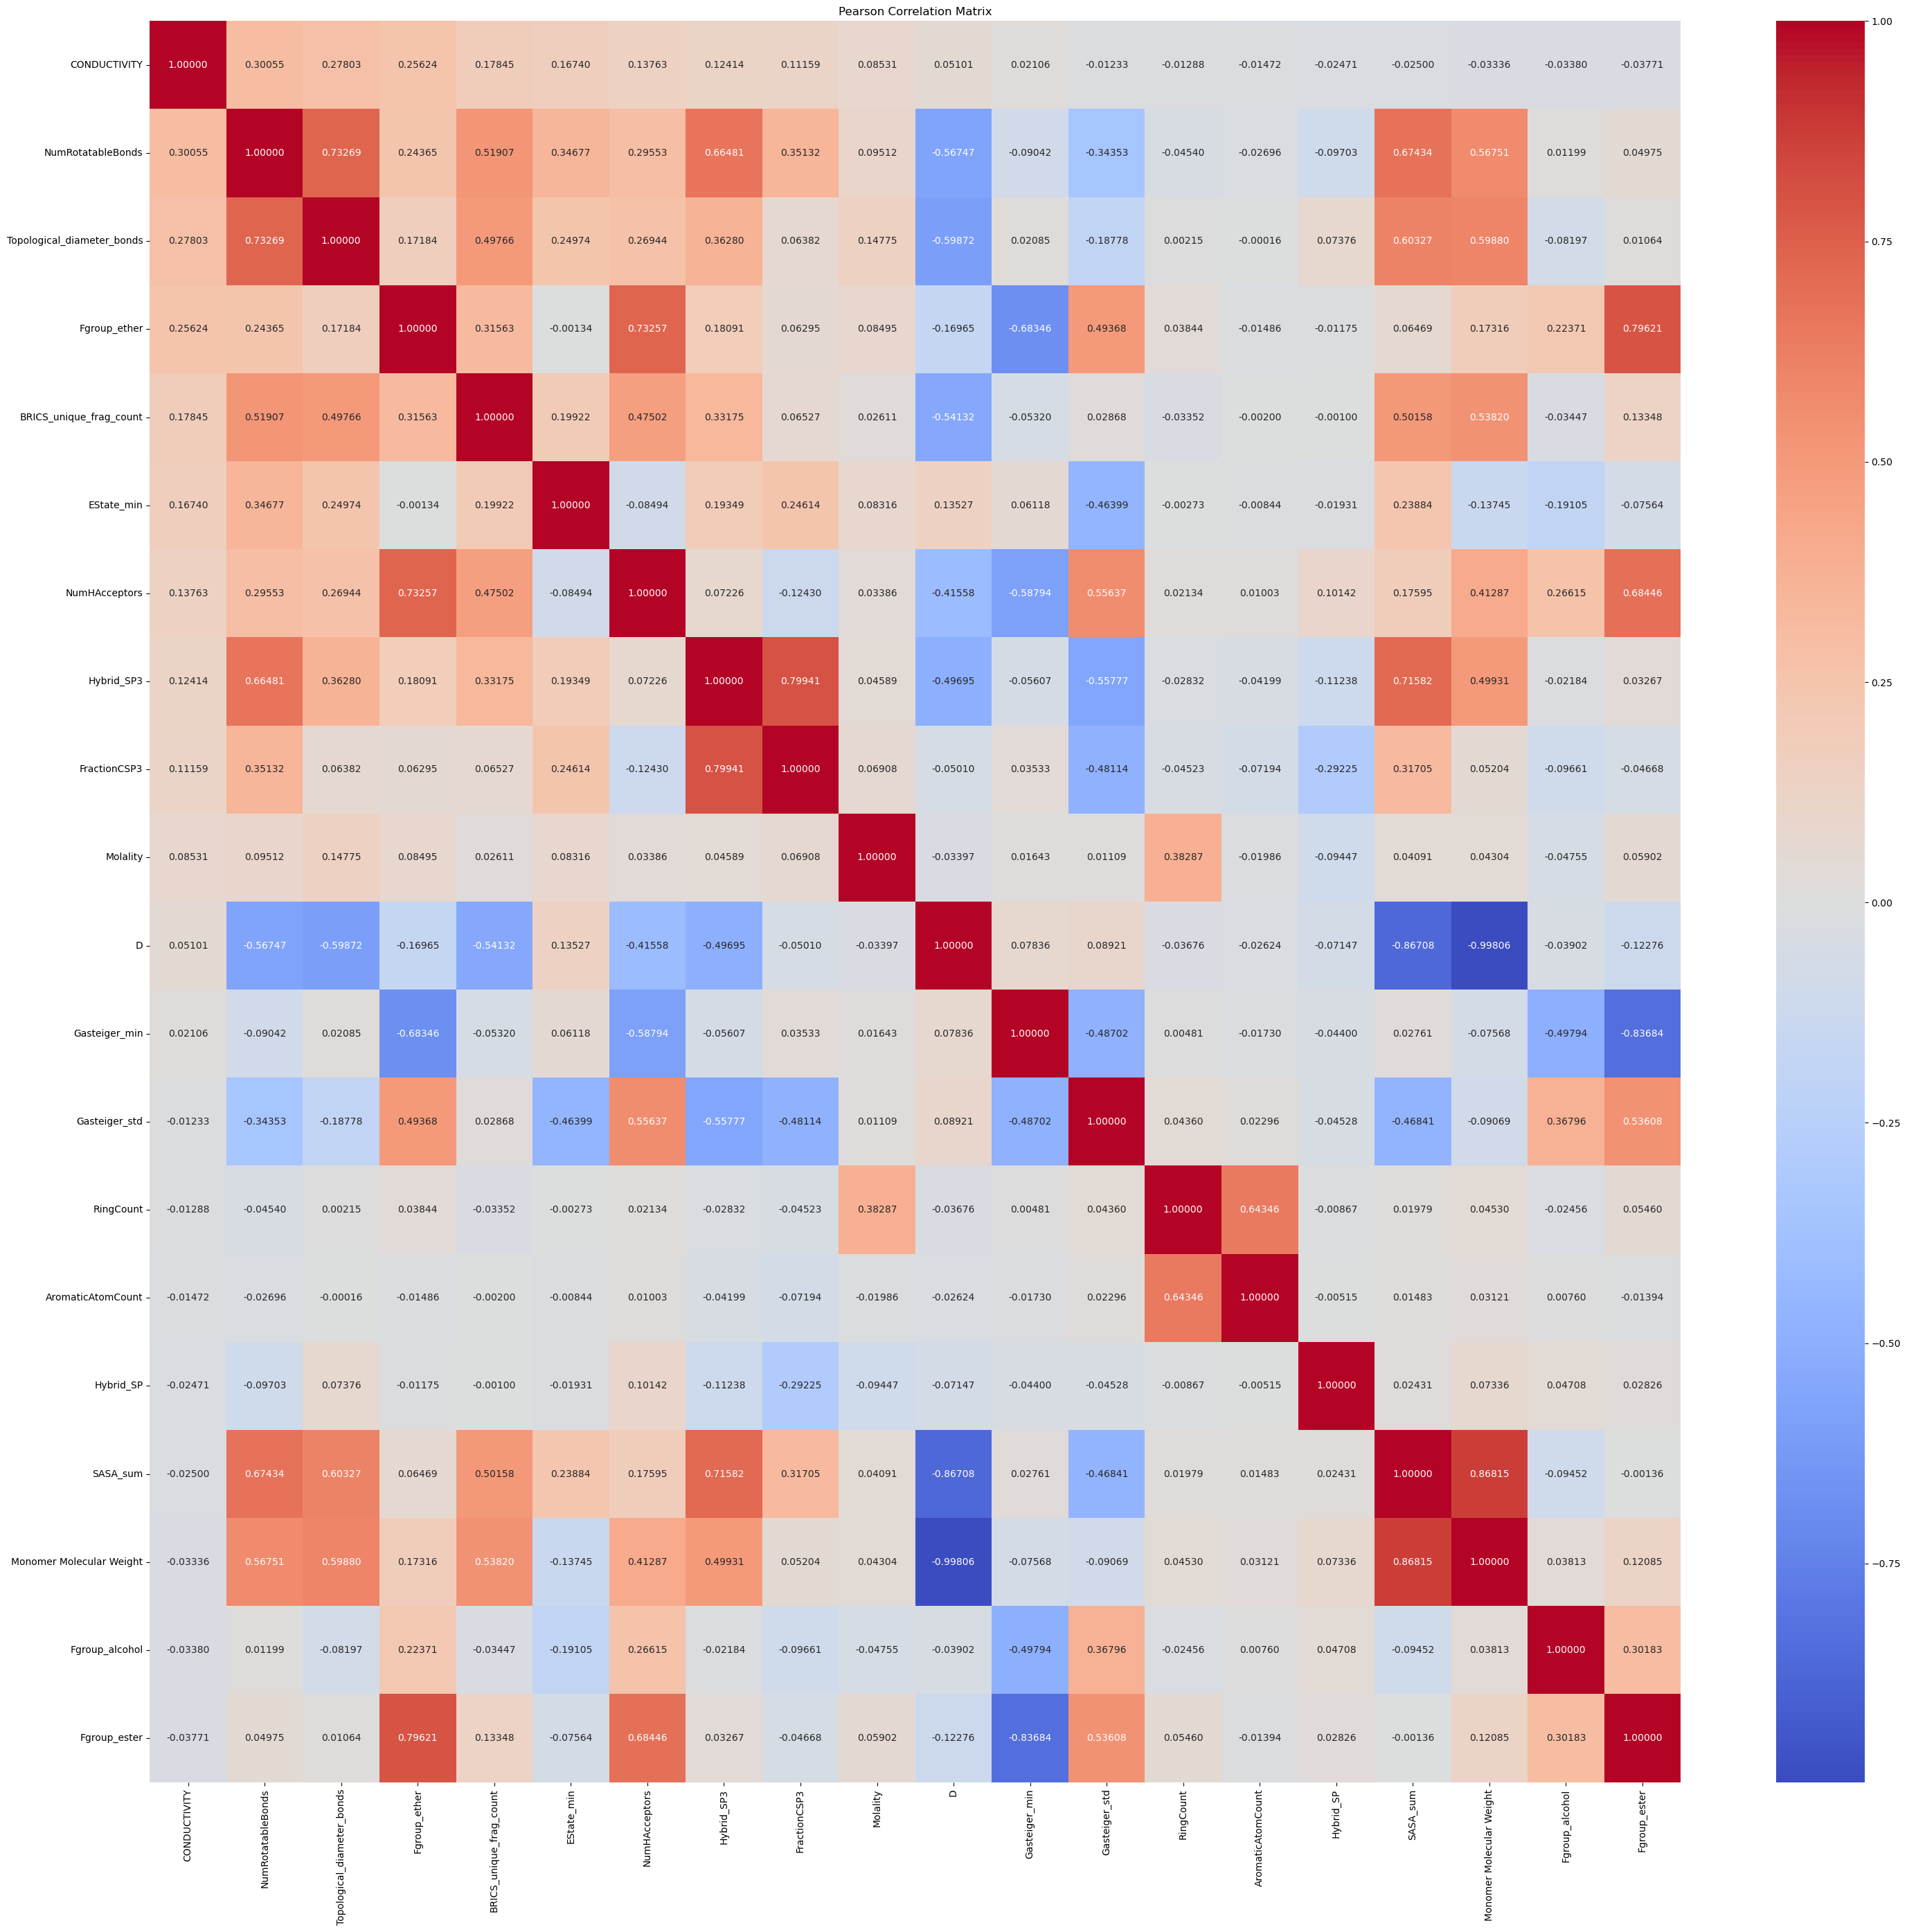

In [46]:
# finally, we visualize the correlations again with the final feature set

numeric_cols = df_final_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

target = "CONDUCTIVITY"
if target not in numeric_cols:
    numeric_cols.append(target)

corr_matrix = df_final_clean[numeric_cols].corr(method="pearson")

# top 20 correlated features with ionic conductivity
corr_target = corr_matrix[target].sort_values(ascending=False)
top20_cols = corr_target.head(20).index.tolist()  

print("\n=== Top 20 Correlations with ionic conductivity ===")
print(corr_target.head(20))

# --- Subset correlation matrix to top 20 ---
corr_top20 = corr_matrix.loc[top20_cols, top20_cols]

# --- Plot heatmap ---
plt.figure(figsize=(30, 28))
sns.heatmap(
    corr_top20,
    annot=True,
    fmt=".5f",
    cmap="coolwarm",
    xticklabels=corr_top20.columns,
    yticklabels=corr_top20.columns
)
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()


Based on the top_20 correlation matrix, the top 3 are number of rotatable bonds, topological paths, and ether groups, while the weakest are molality, pseudo diffusion coefficient, and minimum partial charges. Discussion as to why will be on the paper.

In [47]:
# export to CSV
df_final_clean.to_csv("featurized_ionic_conductivity_dataset.csv", index=False)